In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import unicodedata
from pathlib import Path
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from matplotlib.gridspec import GridSpec

In [2]:
# LOAD CIRCUIT GEOMETRY UNIQUE

circuit_geometry = pd.read_csv('csv_output/Circuit_geometry_unique.csv')

print("Circuit Geometry Dataset")
print(f"Shape: {circuit_geometry.shape}")
print(f"Columns: {circuit_geometry.columns.tolist()}")
print(f"Unique circuits: {circuit_geometry['circuitRef'].nunique()}")


# LOAD COMBINED LAP TIMING CLEAN

lap_timing = pd.read_excel('csv_output/Combined_Lap_Timing_Final.xlsx')

print(f"\nCombined Lap Timing Final Dataset")

print(f"Shape: {lap_timing.shape}")
print(f"Columns: {lap_timing.columns.tolist()}")
print(f"Total Rows: {len(lap_timing)}")



Circuit Geometry Dataset
Shape: (24, 28)
Columns: ['circuitRef', 'year', 'round', 'name', 'type', 'num_drs_zones', 'length_km', 'num_turns', 'slow_corners', 'medium_corners', 'fast_corners', 'flat_corners', 'slow_cluster_max', 'straight_distance_m', 'straight_ratio', 'straight_len_max_m', 'n_major_straights', 'heavy_braking_zones', 'heavy_braking_mean_dv_kmh', 'hb_spacing_std_m', 'hb_at_end_of_max', 'corner_density_tpkm', 'avg_corner_angle', 'total_corner_angle', 'avg_corner_distance', 'drs_zones_detected', 'drs_total_len_m', 'drs_on_max']
Unique circuits: 24

Combined Lap Timing Final Dataset
Shape: (67974, 25)
Columns: ['year', 'round', 'Grand_Prix', 'Name', 'RacingNumber', 'Team', 'lap_number', 'LapTime', 'IntervalToPositionAhead', 'Position', 'Stint', 'Compound', 'New', 'LapInStint', 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall', 'any_violation', 'lap_clean', 'PitStop', 'Pit_Out']
Total Rows: 67974


In [3]:

def filter_clean_racing_laps(df):
    """
    Filter the lap timing dataset to keep only clean racing laps.
    
    Removes rows where:
    - Rainfall is True (wet conditions)
    - any_violation is True (track limits, safety car, etc.)
    - lap_clean is False (outlier/invalid laps)
    - PitIn is True (lap entering pit)
    - PitOut is True (lap exiting pit)
    - LapTime is missing/NaN (removes that row AND the next row)
    - Compound is "UNKNOWN"
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The Combined Lap Timing Clean dataset
    
    Returns:
    --------
    pandas.DataFrame
        Filtered dataset with only clean racing laps
    """
    print("Filtering for clean racing laps")
    print(f"\nInitial rows: {len(df)}")
    
    # Create a copy to avoid modifying the original
    df_filtered = df.copy()
    
    # Step 1: Identify rows with missing LapTime and mark them + next row for removal
    missing_laptime_mask = df_filtered['LapTime'].isna()
    rows_to_remove = missing_laptime_mask.copy()
    
    # Mark the row AFTER each missing LapTime for removal (x+1)
    missing_indices = df_filtered[missing_laptime_mask].index
    for idx in missing_indices:
        # Find the position of this index in the dataframe
        pos = df_filtered.index.get_loc(idx)
        # If there's a next row, mark it for removal
        if pos + 1 < len(df_filtered):
            next_idx = df_filtered.index[pos + 1]
            rows_to_remove.loc[next_idx] = True
    
    print(f"\nRows with missing LapTime: {missing_laptime_mask.sum()}")
    print(f"Total rows to remove (missing + next): {rows_to_remove.sum()}")
    
    # Step 2: Apply all filters - keep rows where all conditions are "clean"
    df_filtered = df_filtered[~rows_to_remove]  # Remove rows with missing LapTime and their next row
    
    initial_after_laptime = len(df_filtered)
    
    # Track compound removals before filtering
    rows_unknown = (df_filtered['Compound'] == 'UNKNOWN').sum()
    rows_intermediate = (df_filtered['Compound'] == 'INTERMEDIATE').sum()
    rows_wet = (df_filtered['Compound'] == 'WET').sum()
    
    df_filtered = df_filtered[
        (df_filtered['Rainfall'] != True) &           # No rain
        (df_filtered['any_violation'] != True) &      # No violations
        (df_filtered['lap_clean'] == True) &          # Lap is clean
        (df_filtered['PitStop'] != True) &            # Not in pit stop
        (df_filtered['Pit_Out'] != True) &            
        (df_filtered['Compound'] != 'UNKNOWN') &       # No unknown compound
        (df_filtered['Compound'] != 'INTERMEDIATE') &  # No intermediate compound
        (df_filtered['Compound'] != 'WET')             # No wet compound
    ]
    
    
    print(f"Rows removed due to compound filtering:")
    print(f"  UNKNOWN compound: {rows_unknown}")
    print(f"  INTERMEDIATE compound: {rows_intermediate}")
    print(f"  WET compound: {rows_wet}")
    print(f"  Total compound removals: {rows_unknown + rows_intermediate + rows_wet}")
    print(f"Rows after all filtering: {len(df_filtered)}")
    print(f"Total rows removed: {len(df) - len(df_filtered)} ({100 * (len(df) - len(df_filtered)) / len(df):.2f}%)")
    
    return df_filtered


# Apply the filter to get clean racing laps
lap_timing_clean = filter_clean_racing_laps(lap_timing)

print("\nClean first filtered Dataset")
print(f"Shape: {lap_timing_clean.shape}")

lap_timing_clean.to_excel('csv_output/Filtered_01_dataset.xlsx', index=False)


Filtering for clean racing laps

Initial rows: 67974

Rows with missing LapTime: 2086
Total rows to remove (missing + next): 3589
Rows removed due to compound filtering:
  UNKNOWN compound: 4082
  INTERMEDIATE compound: 3818
  WET compound: 64
  Total compound removals: 7964
Rows after all filtering: 50821
Total rows removed: 17153 (25.23%)

Clean first filtered Dataset
Shape: (50821, 25)


<h1><center> Now we will further filter the dataset : </center></h1>



- In 2023 , the API failed to identify pit stop for the first 6 races(from Bahrain to Monaco), so Pit stop datas are taken from F1 official web page ( https://www.formula1.com/en/results/2023/races/1141/bahrain/pit-stop-summary)

- Even though we filter for safety, VSC , any violation (track limit and off track), outliers still are present. So manually we will remove for races from 2023 to 2025 accident, puncture ecc( event not related with pure tyre degradation). Below the reader can find year by year the main events from 2023 to 2025

<h1><center> Race analysis </center></h1>




---
<h1><center> 2023 </center></h1>

---


### Bahrain Grand Prix 
- Lap 37: Hamilton–Alonso contact  
- Lap 41: Leclerc mechanical failure  
- Laps 41–42: VSC + yellow flag  

### Saudi Arabian Grand Prix 
- Lap 18: Stroll out  
- Lap 18: Safety car deployed  
- Lap 20: Safety car in → first green lap: 21  
- Lap 26: Albon brake failure (remained on track until lap 27)  

### Australian Grand Prix 
- Lap 1: Yellow flag (Leclerc out)
- Lap 3: Safety car until end of lap 3  
- Lap 7: Albon off-track → yellow  
- Lap 8: Red flag  
- Lap 10: Restart  
- Lap 18: Russell mechanical failure (continued to pits)  
- Lap 47: Verstappen off-track  
- Lap 53: Yellow flag  
- Lap 53: Magnussen crash  
- Lap 55: Red flag  
- Lap 57: Restart (finish lap 58)

### Azerbaijan Grand Prix
- Lap 10: De Vries out → yellow (laps 10–11)  
- Safety car until end lap 13 → first green lap: 14  
- Lap 16: Stroll hit wall  
- Lap 34: Pérez hit wall  

### Monaco Grand Prix
- Lap 11: Sainz contact  
- Lap 11: Pérez–Stroll contact  
- Lap 51: Rain → multiple offs, yellow flags, safety periods  

### Canadian Grand Prix
- Lap 2: Magnussen off-track  
- Lap 7: Sargeant out  
- Lap 12: Russell hit barrier → yellow → safety car  
- Lap 16: Safety car in → first green lap: 17  
- Lap 35: Magnussen–Tsunoda collision (both out)  
- Lap 55: Russell retired  

### Austrian Grand Prix
- Lap 13: Yellow + VSC  
- Lap 16: VSC ending → first green lap: 17  

### British Grand Prix
- Lap 4: Gasly–Stroll collision  
- Lap 32: Safety car deployed (Magnussen stopped)  
- Lap 38: Safety car in → first green lap: 39  

### Singapore Grand Prix
- Lap 1: Tsunoda out  
- Lap 19: Sargeant crash → Safety car until lap 23  
- Lap 23: Safety car in → first green lap: 24  
- Lap 43: Ocon stopped → VSC  
- Lap 45: VSC ending → first green lap: 46  
- Last lap: Russell crash → yellow  

### Qatar Grand Prix
- Lap 1: Hamilton–Russell collision → Safety car  
- Lap 4: Safety car in → first green lap: 5  
- Lap 33: Alonso off-track  
- Laps 39–40: Sargeant retired (illness) → remove laps 39–40  

### United States Grand Prix
- Lap 7: Piastri–Ocon collision → Ocon out  
- Lap 10: Piastri retired  

### Mexico City Grand Prix
- Lap 1: Leclerc–Pérez collision → Pérez out  
- Lap 5: VSC deployed
- Lap 8: Yellow  
- Lap 33: Magnussen crash → safety → red flag  
- Restart on lap 36 → remove lap 36  
- Lap 48–49: Piastri–Tsunoda repeated contact 
- Lap 66: Stroll(18)contact, spin around causing yellow flag
- Lap 67: Yellow  

### São Paulo Grand Prix
- Formation lap: Leclerc out  
- Lap 1: Major crash → red flag  
- Restart on lap 4  
- Russel(63) retire the car on lap 59, so big delta on lap 57 is due to failure.

### Las Vegas Grand Prix
- Laps 1–6: Safety car cycles → remove laps 1–6  
- Lap 17: Piastri puncture → remove lap 17  
- Lap 25: Russell–Verstappen collision → Safety car until lap 28 → first green lap: 29  

---

 <h1><center> 2024 </center></h1>

---


### Australian Grand Prix
- Lap 4: Verstappen mechanical failure → out  
- Lap 17: Hamilton engine failure  
- Lap 17: VSC → ended lap 18 → first green lap: 19  
- Lap 58: Russell crash → yellow → red flag  

### Chinese Grand Prix
- Lap 21: Bottas out → VSC until lap 23  
- Lap 23: Safety car deployed  
- Lap 26: Safety car in → first green lap: 27  
- Lap 27: Stroll–Ricciardo collision → Tsunoda out → remove lap 27  
- Lap 35: Stroll aggressive battling  

### Miami Grand Prix
- Lap 23: VSC deployed
- Lap 28: Sargeant–Magnussen collision → both out  
- Lap 28: Safety car deployed  
- Lap 32: Safety car in → first green lap: 33  

### Canadian Grand Prix
- Very wet conditions  
- Lap 25: Yellow → Safety car  
- Lap 29: Safety car in → first green lap: 30  
- Lap 52: Yellow  
- Lap 54: Sainz–Albon collision → Safety car  
- Lap 58: Safety car in → first green lap: 59  
- Lap 63: Russell off-track  
- Lap 66: Tsunoda spin → yellow  

### Austrian Grand_Prix 
- Lap 64: accident between Verstappen(1)- Norris(4), both puncture
- Lap 66 VSC

### Singapore Grand Prix
- Lap 15: Albon mechanical issue → retired  
- Lap 29: Norris hit barrier (continued) 
- Magnussen(20) retired on lap 57 

### Azerbaijan Grand Prix 
- Lap 1: Stroll(18) puncture 
- Lap 50: Perez(11), Sainz(55) contact , VSC

### United States Grand Prix
- Lap 1: Ocon spin  
- Lap 3: Hamilton out → Safety car  
- Lap 5: Safety car in → first green lap: 6  
- Lap 10: Zhou spin  

### Mexico City Grand Prix
- Lap 1: Albon–Tsunoda collision → Safety car  
- Lap 6: Safety car in → first green lap: 7  
- Lap 10: Verstappen–Norris off-track  
- Lap 16: Alonso retired  
- Lap 18: Pérez–Lawson contact  
- Lap 19: Pérez–Stroll contact  

### Qatar Grand Prix
- Lap 1: Ocon–Hülkenberg–Colapinto collision → yellow → Safety car  
- Lap 4: Safety car in → first green lap: 5  
- Lap 5: Lawson–Bottas contact → yellow  
- Lap 30: Debris (mirror lost)  
- Lap 34: Hamilton puncture  
- Lap 35: Sainz puncture → Safety car  
- Lap 39: Safety car in → first green lap: 40  
- Lap 39: Second safety car  
- Lap 42: Safety car in → first green lap: 43  

### Abu Dhabi Grand Prix
- Lap 1: Piastri–Verstappen contact  
- Lap 1: Pérez spin  
- Lap 2: VSC  
- Lap 3: VSC ending → first green lap: 4  
- Lap 30: Yellow  
- Lap 31: Bottas puncture  
- Lap 31: Magnussen spin  

---

<h1><center> 2025 </center></h1>

---


### Australian Grand Prix
- Wet race → removed  

### Bahrain Grand Prix
- Lap 32: Safety car deployed  
- Lap 35: Safety car in → first green lap: 36  

### Miami Grand_Prix
- Lap 1: Accident for Doohan
- Lap 2: Safety can deployed
- Lap 3: Safety car in → first green lap:4
- Lap 10: Alonso(14) spin around 
- Lap 28: Bearman(87) failure, VSC deployed
- Lap 30: VSC ending 
- Lap 33-34: VSC



### Emilia Romagna Grand Prix
- Lap 3: Gasly off-track  
- Lap 29: Ocon engine failure → stopped on track  
- Lap 31: VSC deployed  
- Lap 32: VSC ending → first green lap: 33  
- Lap 46: Antonelli engine failure → stopped on track  
- Lap 46: Safety car deployed  
- Lap 53: Safety car in → first green lap: 54  

### Monaco Grand Prix
- Lap 1: VSC deployed  
- Lap 5: VSC ending → first green lap: 5  
- Laps 8–9: Gasly no tyre → yellow  
- Lap 38: Alonso out → yellow  

### Spanish Grand Prix
- Lap 29: Albon retired  
- Lap 31: Lawson–Bearman collision  
- Lap 55: Antonelli out → yellow  
- Lap 55: Safety car deployed  
- Lap 60: Safety car in → first green lap: 61  

### Austrian Grand Prix
- Lap 1: Safety car deployed  
- Lap 3: Safety car in → first green lap: 4  
- Lap 31: Colapinto–Tsunoda contact → Colapinto spin (continued)  

### Dutch Grand Prix
- Lap 23: Hamilton out → Safety car deployed  
- Lap 26: Safety car in → first green lap: 27  
- Lap 31: VSC  
- Lap 32: VSC ending  
- Lap 53: Safety car deployed  
- Lap 57: Safety car in → first green lap: 58  
- Lap 65: Yellow → Norris out → Safety car deployed  
- Lap 68: Safety car in → first green lap: 69  

### Italian Grand Prix
- Lap 24: Alonso car failure  
- Lap 41: contact between Sain(55) and Bearman(87), spin around and they keep going 


### Singapore Grand Prix
- Lap 61: Hamilton car failure  

In [7]:

def norm_gp(s: str) -> str:
    """Normalize Grand_Prix label: lowercase, strip, remove accents, unify underscores/spaces."""
    if pd.isna(s): return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.replace("_", " ").lower().strip()
    s = " ".join(s.split())
    return s

def expand_laps(spec):
    """
    Accepted specs:
      int -> {int}
      (a,b) -> inclusive range
      ("upto", n) -> {1..n}
      ("from", n) -> marker ('from', n)
    Returns: (set(int), from_start or None)
    """
    laps = set()
    from_start = None
    if isinstance(spec, int):
        laps.add(spec)
    elif isinstance(spec, tuple) and len(spec) == 2:
        a, b = spec
        if isinstance(a, int) and isinstance(b, int):
            lo, hi = sorted((a, b))
            laps |= set(range(lo, hi + 1))
        elif a == "upto":
            laps |= set(range(1, int(b) + 1))
        elif a == "from":
            from_start = int(b)
        else:
            raise ValueError(f"Bad lap spec: {spec}")
    else:
        raise ValueError(f"Bad lap spec: {spec}")
    return laps, from_start

def add_rule(year_rules, gp, laps, numbers=None):
    year_rules.append({"gp": gp, "laps": laps, "numbers": None if numbers is None else list(numbers)})

# load input 

in_path = Path("csv_output/Filtered_01_dataset.xlsx")
df = pd.read_excel(in_path)

required = {"year","Grand_Prix","RacingNumber","lap_number"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in input: {missing}")

df["_gp_key"] = df["Grand_Prix"].map(norm_gp)
df["RacingNumber"] = pd.to_numeric(df["RacingNumber"], errors="coerce").astype("Int64")

# RULES

# 2023

RULES_2023 = []
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(14,15), (36,37)], [1])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (30,31), (40,41)], [2])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(17,18), (27,28), (37,38),(40), (47,48), (54,55)], [4])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(9,10), (25,26), (40,41)], [10])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(17,18), (34,35)], [11])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(14,15), (34,35)], [14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (33,34)], [16])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(15,16), (30,31)], [18])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(15,16), (29,30), (40,41)], [20])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12), (27,28)], [21])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(10,11), (26,27), (40,41)], [22])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(10,11), (26,27), (40,41)], [23])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (32,33), (54,55)], [24])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12),(26,27),(40,41)], [27])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (15,16), (32,33)], [31])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(12,13), (30,31)], [44])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (31,32)], [55])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(13,14), (31,32)], [63])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(11,12), (29,30)], [77])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [37], [44,14])
add_rule(RULES_2023, "Bahrain_Grand_Prix", [(41,42)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,20)], None)
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(26,27)], [23])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [1])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(12,19)], [2])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(2,3), (19,20)], [4])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(14,15)], [10])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [11])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(14,19)], [14])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(16,17)], [16])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(13,14)], [18])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(8,9)], [20])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [21])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [22])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(17,18)], [23])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(11,12), (18,19)], [24])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(11,12)], [27])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(16,17)], [31])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [44])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(15,16)], [55])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(18,19)], [63])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(9,10), (17,18)], [77])
add_rule(RULES_2023, "Saudi_Arabian_Grand_Prix", [(1,2)], [81])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,3)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,10)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(18)], None)   # russel failure , yellow flag lap 
add_rule(RULES_2023, "Australian_Grand_Prix", [18], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [47], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(53,58)], None)
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [1])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (2,3), (8,9), (36,37),(54,55), (55,56)], [2])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [4])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9),(55,56)], [10])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (57,58)], [11])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56)], [14])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [18])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (8,9)], [20])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (45,46), (54,55), (55,56)], [21])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55),(55,56)], [22])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55), (55,56), (57,58)], [24])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [27])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (55,56)], [31])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (55,56), (57,58)], [44])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (57,58)], [55])
add_rule(RULES_2023, "Australian_Grand_Prix", [(7,8), (8,9)], [63])
add_rule(RULES_2023, "Australian_Grand_Prix", [(1,2), (8,9), (54,55), (55,56)], [77])
add_rule(RULES_2023, "Australian_Grand_Prix", [(8,9), (54,55), (55,56), (57,58)], [81])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,13)], None)
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [16], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [34], [11])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,11)], [1])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [2])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(9,10)], [4])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(5,6), (23,24)], [10])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [11])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [14])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [16])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [18])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(10,11)], [20])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [22])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(7,8)], [23])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [24])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(50,51)], [31])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(9,10)], [44])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12)], [55])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(11,12), (49,50)], [63])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(6,7),(12,13)], [77])
add_rule(RULES_2023, "Azerbaijan_Grand_Prix", [(8,9)], [81])
add_rule(RULES_2023, "Miami_Grand_Prix", [(45,46)], [1])
add_rule(RULES_2023, "Miami_Grand_Prix", [(2,3)], [2])
add_rule(RULES_2023, "Miami_Grand_Prix", [(4,5)], [4])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16)], [10])
add_rule(RULES_2023, "Miami_Grand_Prix", [(20,21)], [11])
add_rule(RULES_2023, "Miami_Grand_Prix", [(24,25)], [14])
add_rule(RULES_2023, "Miami_Grand_Prix", [(17,18)], [16])
add_rule(RULES_2023, "Miami_Grand_Prix", [(42,43)], [18])
add_rule(RULES_2023, "Miami_Grand_Prix", [(14,15)], [20])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16)], [21])
add_rule(RULES_2023, "Miami_Grand_Prix", [(36,37)], [22])
add_rule(RULES_2023, "Miami_Grand_Prix", [(22,23)], [23])
add_rule(RULES_2023, "Miami_Grand_Prix", [(31,32)], [24])
add_rule(RULES_2023, "Miami_Grand_Prix", [(33,34)], [27])
add_rule(RULES_2023, "Miami_Grand_Prix", [(39,40)], [31])
add_rule(RULES_2023, "Miami_Grand_Prix", [(37,38)], [44])
add_rule(RULES_2023, "Miami_Grand_Prix", [(18,19)], [55])
add_rule(RULES_2023, "Miami_Grand_Prix", [(17,18)], [63])
add_rule(RULES_2023, "Miami_Grand_Prix", [(15,16), (17,18)], [77])
add_rule(RULES_2023, "Miami_Grand_Prix", [(5,6)], [81])
add_rule(RULES_2023, "Monaco_Grand_Prix", [11], [55,11,18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [("from", 51)], None)
add_rule(RULES_2023, "Monaco_Grand_Prix", [(55,56)], [1])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(20,21),(23,24), (52,53)], [2])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(50,51)], [4])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(47,48), (54,55)], [10])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (34,35),(53,54), (57,58), (70,71)], [11])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55), (55,56)], [14])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(44,45), (55,56)], [16])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(51,52)], [18])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(56,57)], [20])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(53,54)], [21])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(53,54)], [22])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(18,19), (52,53)], [23])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (52,53)], [24])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(1,2), (59,60)], [27])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(32,33), (54,55)], [31])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(31,32), (54,55)], [44])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(33,34), (55,56)], [55])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55)], [63])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(51,52)], [77])
add_rule(RULES_2023, "Monaco_Grand_Prix", [(54,55)], [81])
add_rule(RULES_2023, "Canadian_Grand_Prix", [2], [20])
add_rule(RULES_2023, "Canadian_Grand_Prix", [7], [2])
add_rule(RULES_2023, "Canadian_Grand_Prix", [(12,16)], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [35], None)
add_rule(RULES_2023, "Canadian_Grand_Prix", [55], [63])
add_rule(RULES_2023, "Austrian_Grand_Prix", [(13,16)], None)
add_rule(RULES_2023, "British_Grand_Prix", [(32,38)], None)
add_rule(RULES_2023, "British_Grand_Prix", [4], [10,18])
add_rule(RULES_2023, "Singapore_Grand_Prix", [(19,23)], None)
add_rule(RULES_2023, "Singapore_Grand_Prix", [(43,45)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [(1,4)], None)
add_rule(RULES_2023, "Qatar_Grand_Prix", [33], [14])
add_rule(RULES_2023, "Qatar_Grand_Prix", [(39,40)], [2])
add_rule(RULES_2023, "United_States_Grand_Prix", [7], [31,81])
add_rule(RULES_2023, "United_States_Grand_Prix", [(8,10)], [81])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [1], [16,11])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [5], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [8], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [66], [18])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(33,36)], None)
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [(48,49)], [81,22])
add_rule(RULES_2023, "Mexico_City_Grand_Prix", [67], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(1,3)], None)
add_rule(RULES_2023, "Sao_Paulo_Grand_Prix", [(57)],[63]) # russel mechanical issue
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [("upto", 6)], None)
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [17], [81])
add_rule(RULES_2023, "Las_Vegas_Grand_Prix", [(25,28)], None)


# 2024

RULES_2024 = []
add_rule(RULES_2024, "Australian_Grand_Prix", [4], [1])
add_rule(RULES_2024, "Australian_Grand_Prix", [17], [44])
add_rule(RULES_2024, "Australian_Grand_Prix", [(17,18)], None)
add_rule(RULES_2024, "Australian_Grand_Prix", [(57,58)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [(21,26)], None)
add_rule(RULES_2024, "Chinese_Grand_Prix", [27], [18,3,22])
add_rule(RULES_2024, "Chinese_Grand_Prix", [35], [18])
add_rule(RULES_2024, "Miami_Grand_Prix", [23], None)
add_rule(RULES_2024, "Miami_Grand_Prix", [(28,32)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(25,29)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [52], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [(54,58)], None)
add_rule(RULES_2024, "Canadian_Grand_Prix", [63], [63])
add_rule(RULES_2024, "Canadian_Grand_Prix", [66], None)
add_rule(RULES_2024, "Singapore_Grand_Prix", [15], [23])  # Albon mechanical issue
add_rule(RULES_2024, "Singapore_Grand_Prix", [29], [4])
add_rule(RULES_2024, "Singapore_Grand_Prix", [57], [20])
add_rule(RULES_2024, "Austrian_Grand_Prix", [(65,66)], None)
add_rule(RULES_2024, "Austrian_Grand_Prix", [64], [1])
add_rule(RULES_2024, "Austrian_Grand_Prix", [(64)], [4])
add_rule(RULES_2024, "Azerbaijan_Grand_Prix", [(49,51)], None) # accident lap on first turn of lap 50, influence lap 49 for some cars
add_rule(RULES_2024, "United_States_Grand_Prix", [1], [31])
add_rule(RULES_2024, "United_States_Grand_Prix", [(3,5)], None)
add_rule(RULES_2024, "United_States_Grand_Prix", [10], [24])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [(1,6)], None)
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [10], [1,4])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [16], [14])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [18], [11,30])
add_rule(RULES_2024, "Mexico_City_Grand_Prix", [19], [11,18])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(1,4)], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [5], [30,77])
add_rule(RULES_2024, "Qatar_Grand_Prix", [30], None)
add_rule(RULES_2024, "Qatar_Grand_Prix", [34], [44])
add_rule(RULES_2024, "Qatar_Grand_Prix", [35], [55])
add_rule(RULES_2024, "Qatar_Grand_Prix", [(35,42)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [(1,3)], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [30], None)
add_rule(RULES_2024, "Abu_Dhabi_Grand_Prix", [31], [77,20])


# 2025

RULES_2025 = []
add_rule(RULES_2025, "Australian_Grand_Prix", [("from", 1)], None)
add_rule(RULES_2025, "Bahrain_Grand_Prix", [(32,35)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [3], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [29], [10])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(31,32)], None)
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [46], [12])
add_rule(RULES_2025, "Emilia_Romagna_Grand_Prix", [(45,53)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [(1,3)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [10], [14])
add_rule(RULES_2025, "Miami_Grand_Prix", [(28,30)], None)
add_rule(RULES_2025, "Miami_Grand_Prix", [(33,34)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(1,5)], None)
add_rule(RULES_2025, "Monaco_Grand_Prix", [(8,9)], [10])
add_rule(RULES_2025, "Monaco_Grand_Prix", [38], None)
add_rule(RULES_2025, "Spanish_Grand_Prix", [29], [23])
add_rule(RULES_2025, "Spanish_Grand_Prix", [31], [30,87])
add_rule(RULES_2025, "Spanish_Grand_Prix", [(54,60)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [(1,3)], None)
add_rule(RULES_2025, "Austrian_Grand_Prix", [31], [43,22])
add_rule(RULES_2025, "Dutch_Grand_Prix", [23], [44])
add_rule(RULES_2025, "Dutch_Grand_Prix", [(23,26)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(31,32)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(53,57)], None)
add_rule(RULES_2025, "Dutch_Grand_Prix", [(65,68)], None)
add_rule(RULES_2025, "Italian_Grand_Prix", [24], [14])
add_rule(RULES_2025, "Italian_Grand_Prix", [41], [55,87])
add_rule(RULES_2025, "Singapore_Grand_Prix", [61], [44])

# Bundle by year

RULES_BY_YEAR = {
    2023: RULES_2023,
    2024: RULES_2024,
    2025: RULES_2025,
}

# APPLY ALL YEARS

to_drop = pd.Series(False, index=df.index)

for yr, rules in RULES_BY_YEAR.items():
    df_y = df[df["year"] == yr]
    if df_y.empty:
        continue

    race_max = (
        df_y.groupby(["_gp_key"])["lap_number"]
            .max().rename("max_lap").reset_index()
    )

    for r in rules:
        gp_key = norm_gp(r["gp"])
        subset = df_y[df_y["_gp_key"] == gp_key]
        if subset.empty:
            continue

        mx = race_max[race_max["_gp_key"] == gp_key]
        max_lap = int(mx["max_lap"].iloc[0]) if not mx.empty else int(subset["lap_number"].max())

        lap_mask = pd.Series(False, index=subset.index)
        for spec in r["laps"]:
            laps_set, from_start = expand_laps(spec)
            if from_start is not None:
                laps_set |= set(range(from_start, max_lap + 1))
            lap_mask |= subset["lap_number"].isin(laps_set)

        if r["numbers"] is None:
            idx = subset[lap_mask].index
        else:
            idx = subset[lap_mask & subset["RacingNumber"].isin(r["numbers"])].index

        to_drop.loc[idx] = True

df["manual_exclude"] = to_drop
df["exclude_reason"] = np.where(df["manual_exclude"], "manual_incident", "")

kept = df.loc[~df["manual_exclude"]].drop(columns=["_gp_key"])
removed = df.loc[df["manual_exclude"]].drop(columns=["_gp_key"])

# Save
out_dir = Path("csv_output")
out_dir.mkdir(parents=True, exist_ok=True)
kept.to_excel(out_dir / "Filtered_02_manual_clean.xlsx", index=False)
removed.to_excel(out_dir / "Filtered_02_manual_removed.xlsx", index=False)

print(f"Removed: {len(removed):,} laps")
print(f"Kept: {len(kept):,} laps")
print(f"✓ Saved: csv_output/Filtered_02_manual_clean.xlsx")
print(f"✓ Saved: csv_output/Filtered_02_manual_removed.xlsx")


Removed: 1,516 laps
Kept: 49,305 laps
✓ Saved: csv_output/Filtered_02_manual_clean.xlsx
✓ Saved: csv_output/Filtered_02_manual_removed.xlsx


In [9]:

def compute_stint_metrics(df):
    """
    Compute stint length and relative progress based on physical lap progression.
    
    This function calculates:
    - stint_length: Maximum physical LapInStint reached in each stint (true tyre age)
    - rel_stint_progress: Relative position in stint (LapInStint / stint_length)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Filtered lap timing dataset with columns: year, round, RacingNumber, 
        Stint, LapInStint
    
    Returns:
    --------
    pandas.DataFrame
        Input dataframe with added columns: stint_length, rel_stint_progress
    """
    # Copy to avoid modifying original
    df = df.copy()
    
    # Sort by year, round, driver, stint, and physical lap order
    df = df.sort_values(["year", "round", "RacingNumber", "Stint", "LapInStint"]).copy()
    
    # Compute total PHYSICAL laps in each stint (max LapInStint reached)
    # This preserves the true tyre age even if some laps were filtered out
    df["stint_length"] = df.groupby(["year", "round", "RacingNumber", "Stint"])["LapInStint"].transform("max")
    
    # Relative progress through the stint (0 to 1)
    df["rel_stint_progress"] = df["LapInStint"] / df["stint_length"]
    
    return df

#Load the manually cleaned dataset for delta computation

print("Loadin Filtered_02_manual_clean.xlsx")
lap_timing_manual_clean = pd.read_excel('csv_output/Filtered_02_manual_clean.xlsx')

# Apply stint metrics computation
df = compute_stint_metrics(lap_timing_manual_clean)


def build_deltas_for_driver_race(g):
    """
    Compute lap-to-lap deltas for consecutive physical laps, excluding anomalous transitions.
    """
    g = g.sort_values(["Stint", "LapInStint"]).copy()
    
    # Get previous lap info within each stint
    g["LapTime_prev"] = g.groupby("Stint")["LapTime"].shift(1)
    g["LapInStint_prev"] = g.groupby("Stint")["LapInStint"].shift(1)
    
    # Check if laps are consecutive
    g["is_consecutive"] = g["LapInStint_prev"] == (g["LapInStint"] - 1)
    
    # Calculate delta
    g["delta_laptime"] = g["LapTime"] - g["LapTime_prev"]
    
    # Detect anomalous previous laps (SC/VSC/incident)
    median_laptime = g["LapTime"].median()
    g["prev_lap_is_anomaly"] = g["LapTime_prev"] > (median_laptime * 1.20)
    g["delta_is_extreme"] = g["delta_laptime"].abs() > 10.0
    
    # Keep only valid transitions
    valid_mask = (
        g["is_consecutive"] & 
        g["LapTime_prev"].notna() & 
        ~g["prev_lap_is_anomaly"] & 
        ~g["delta_is_extreme"]
    )
    
    return g[valid_mask].copy()

# Apply to each driver per race
df_pairs = df.groupby(["year", "round", "RacingNumber"], group_keys=False).apply(build_deltas_for_driver_race)

print(f"\nClean filtered dataset: {len(df)} laps")
print(f"Valid consecutive lap pairs: {len(df_pairs)} transitions ({100*len(df_pairs)/len(df):.1f}%)")

print(f"\nΔLapTime statistics:")
print(f"  Mean: {df_pairs['delta_laptime'].mean():.3f}s")
print(f"  Std: {df_pairs['delta_laptime'].std():.3f}s")
print(f"  Min: {df_pairs['delta_laptime'].min():.3f}s")
print(f"  Max: {df_pairs['delta_laptime'].max():.3f}s")

# save the pairs with delta lap time for inspection
df_pairs.to_excel('csv_output/Filtered_03_with_deltas.xlsx', index=False)

Loadin Filtered_02_manual_clean.xlsx

Clean filtered dataset: 49305 laps
Valid consecutive lap pairs: 44822 transitions (90.9%)

ΔLapTime statistics:
  Mean: -0.002s
  Std: 0.651s
  Min: -9.960s
  Max: 9.787s


<h1><center>Delta lap time distribution </center></h1>


Delta LapTime Distribution Visualization


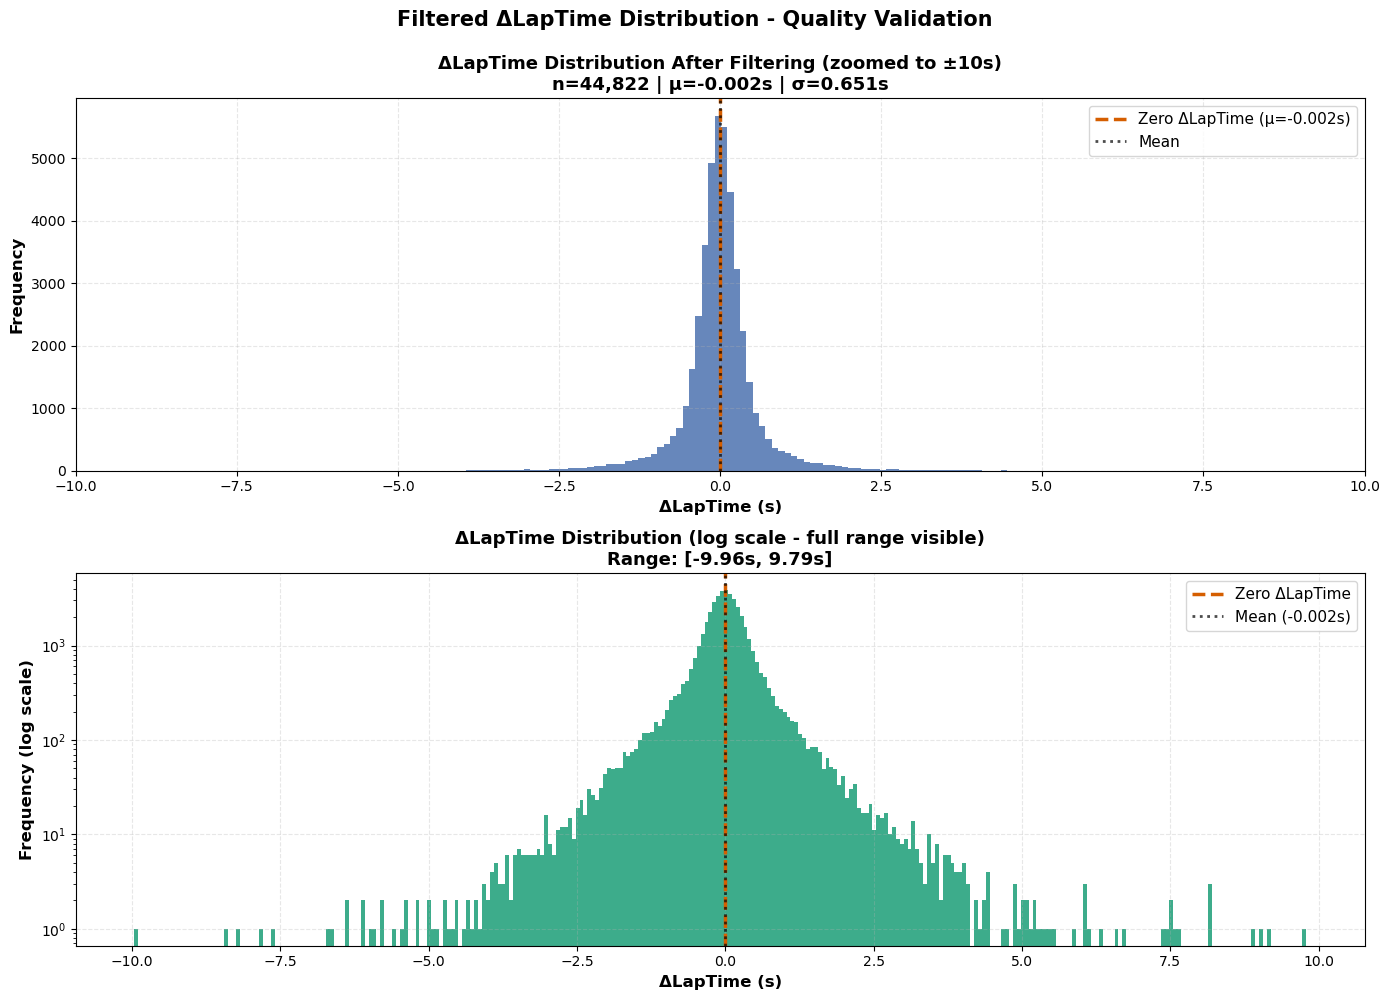


ΔLapTime Summary:
  Transitions: 44,822
  Mean: -0.0023s
  Std: 0.6506s
  Median: -0.0040s
  Range: [-9.960s, 9.787s]
  95th percentile: ±1.322s
  99th percentile: ±2.510s


In [10]:

def visualize_delta_distribution(df, delta_col="delta_laptime"):
    """
    Visualize ΔLapTime distribution after filtering (validation plots).
    No additional data removal - just diagnostic visualization.
    """
    x = df[delta_col].dropna()
    
    print("\n" + "="*90)
    print("Delta LapTime Distribution Visualization")
    print("="*90)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color palette
    color_main = "#4C72B0"      # blue
    color_zero = "#D55E00"      # red/orange
    color_green = "#1B9E77"     # green
    
    # Plot 1: Zoomed view (±10s)
    axes[0].hist(x, bins=200, color=color_main, edgecolor="none", alpha=0.85)
    axes[0].axvline(0, color=color_zero, linestyle="--", linewidth=2.5, 
                    label=f"Zero ΔLapTime (μ={x.mean():.3f}s)")
    axes[0].axvline(x.mean(), color="black", linestyle=":", linewidth=2, 
                    label=f"Mean", alpha=0.7)
    axes[0].set_xlim(-10, 10)
    axes[0].set_xlabel("ΔLapTime (s)", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Frequency", fontsize=12, fontweight="bold")
    axes[0].set_title(
        f"ΔLapTime Distribution After Filtering (zoomed to ±10s)\n"
        f"n={len(x):,} | μ={x.mean():.3f}s | σ={x.std():.3f}s",
        fontsize=13, fontweight="bold"
    )
    axes[0].legend(fontsize=11, loc='upper right')
    axes[0].grid(True, alpha=0.3, linestyle="--")
    
    # Plot 2: Log scale (full range - see tails)
    axes[1].hist(x, bins=300, color=color_green, edgecolor="none", alpha=0.85)
    axes[1].axvline(0, color=color_zero, linestyle="--", linewidth=2.5, 
                    label="Zero ΔLapTime")
    axes[1].axvline(x.mean(), color="black", linestyle=":", linewidth=2, 
                    label=f"Mean ({x.mean():.3f}s)", alpha=0.7)
    axes[1].set_xlabel("ΔLapTime (s)", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Frequency (log scale)", fontsize=12, fontweight="bold")
    axes[1].set_yscale("log")
    axes[1].set_title(
        f"ΔLapTime Distribution (log scale - full range visible)\n"
        f"Range: [{x.min():.2f}s, {x.max():.2f}s]",
        fontsize=13, fontweight="bold"
    )
    axes[1].legend(fontsize=11, loc='upper right')
    axes[1].grid(True, alpha=0.3, linestyle="--")
    
    fig.suptitle(
        "Filtered ΔLapTime Distribution - Quality Validation",
        fontsize=15, fontweight="bold", y=0.995
    )
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nΔLapTime Summary:")
    print(f"  Transitions: {len(x):,}")
    print(f"  Mean: {x.mean():.4f}s")
    print(f"  Std: {x.std():.4f}s")
    print(f"  Median: {x.median():.4f}s")
    print(f"  Range: [{x.min():.3f}s, {x.max():.3f}s]")
    print(f"  95th percentile: ±{x.abs().quantile(0.95):.3f}s")
    print(f"  99th percentile: ±{x.abs().quantile(0.99):.3f}s")
    


# Generate validation plots
visualize_delta_distribution(df_pairs, delta_col="delta_laptime")

<h1><center> Delta Lap time distribution by tyre compound </center></h1>

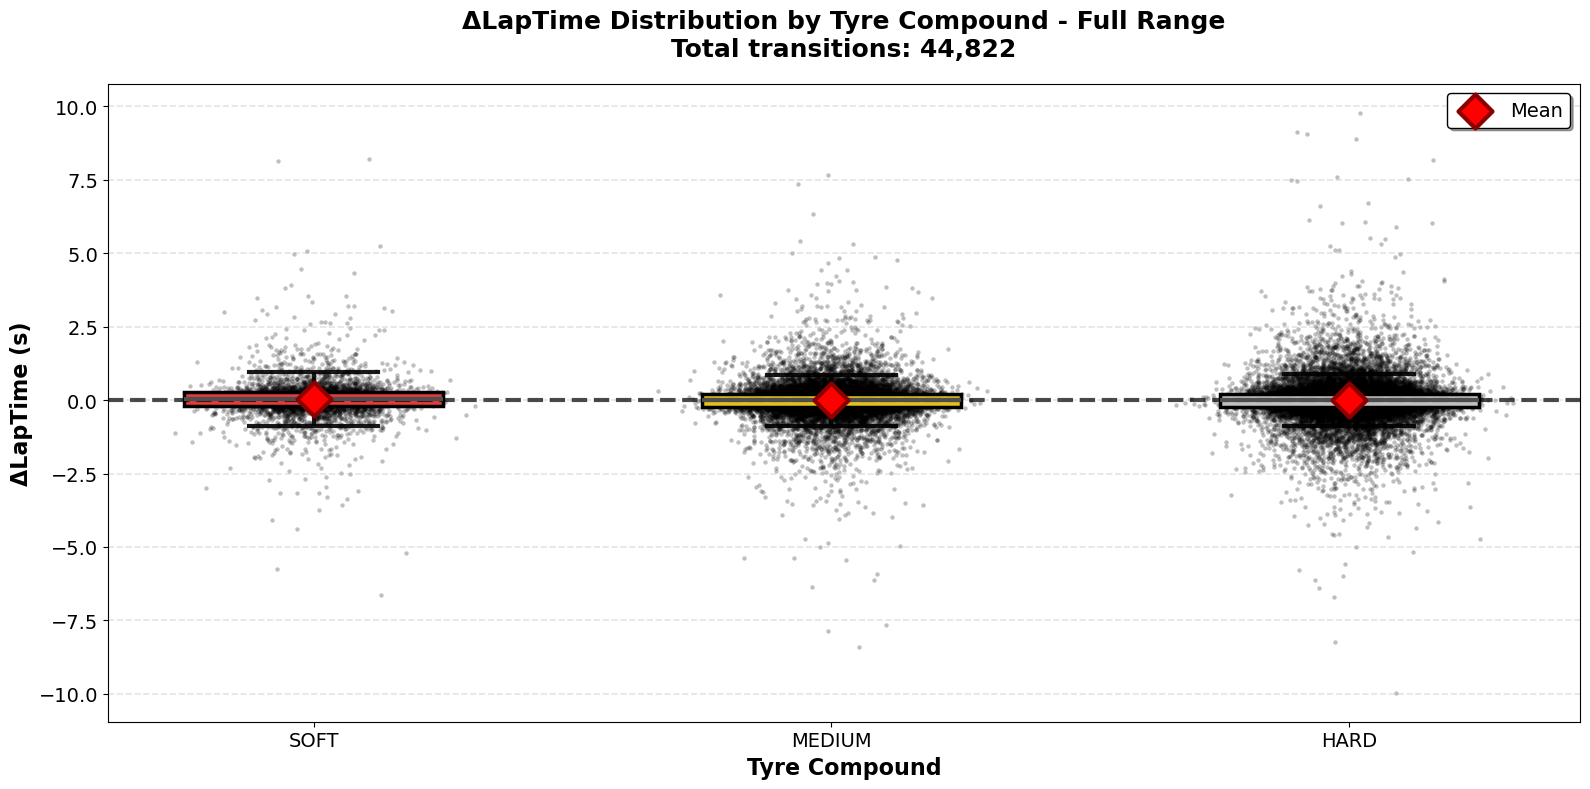


Full Range Statistics
            mean  median     std  count
Compound                               
HARD     -0.0082 -0.0100  0.6807  24005
MEDIUM   -0.0045 -0.0050  0.6033  16629
SOFT      0.0408  0.0415  0.6530   4188


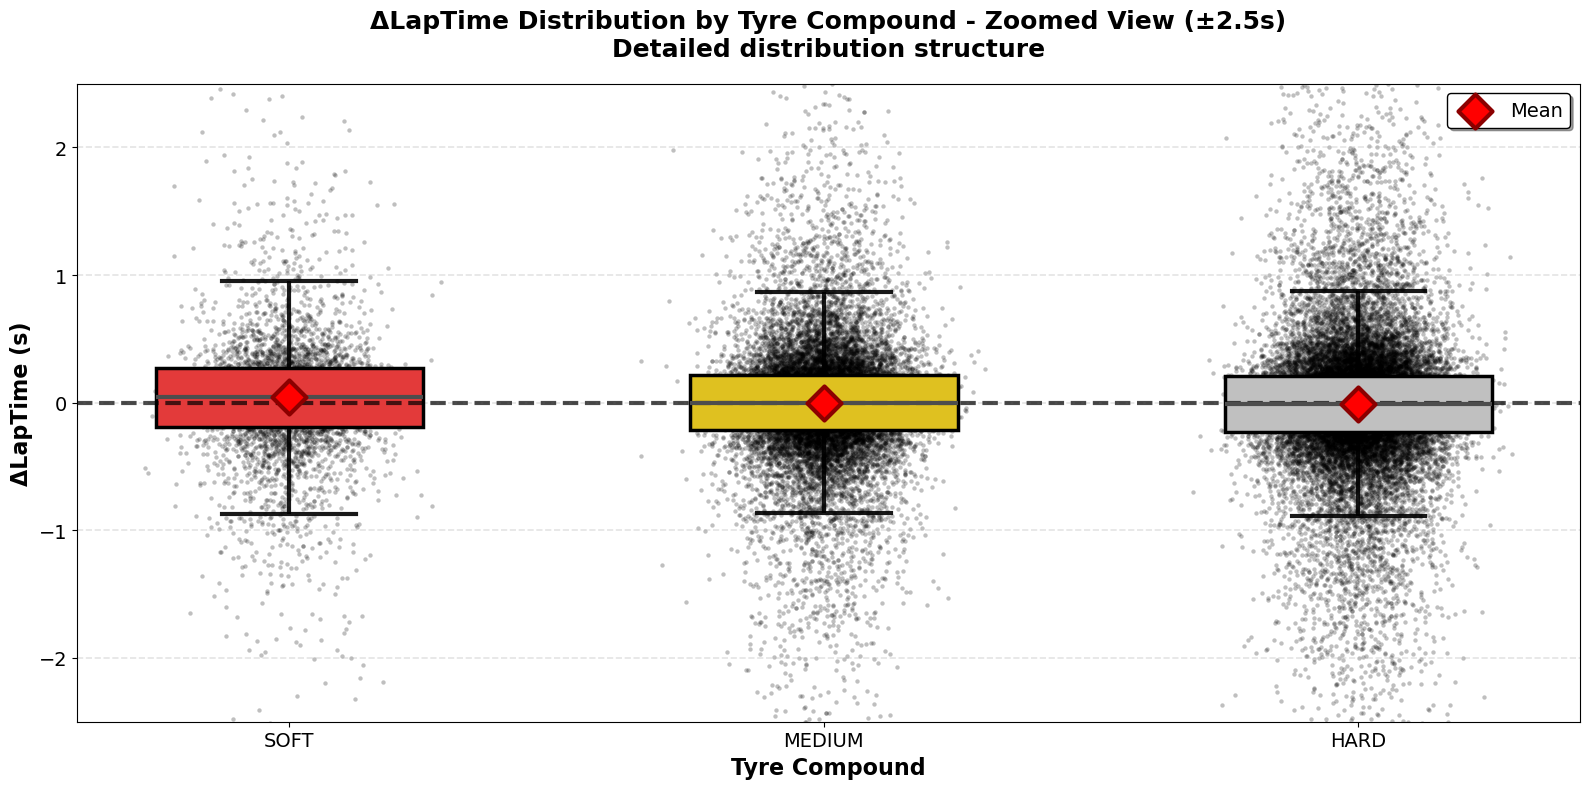

In [96]:

def plot_delta_full_range(df, delta_col="delta_laptime", sample_points=40000):
    """
    Full range boxplot - see all extreme values.
    """
    compounds = ["SOFT", "MEDIUM", "HARD"]
    df = df[df["Compound"].isin(compounds)].copy()
    
    palette = {"SOFT": "#FF1E1E", "MEDIUM": "#FFD700", "HARD": "#C0C0C0"}
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    stats = df.groupby("Compound")[delta_col].agg(['mean', 'median', 'std', 'count'])
    
    # Boxplot
    bp = sns.boxplot(
        data=df, x="Compound", y=delta_col, order=compounds,
        palette=palette, width=0.5, linewidth=3,
        showfliers=False, ax=ax,
        whiskerprops=dict(color='black', linewidth=3, alpha=0.9),  # WHISKERS
        capprops=dict(color='black', linewidth=3, alpha=0.9) 
    )
    
    for patch in bp.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(2.5)
    
    # Sample and plot points
    for i, comp in enumerate(compounds):
        comp_data = df[df["Compound"] == comp][delta_col]
        if len(comp_data) > sample_points:
            sample_idx = np.random.choice(len(comp_data), sample_points, replace=False)
            plot_data = comp_data.iloc[sample_idx]
        else:
            plot_data = comp_data
        
        x_jitter = np.random.normal(i, 0.08, size=len(plot_data))
        ax.scatter(x_jitter, plot_data, color='black', s=10, alpha=0.25, linewidths=0)
    
    # Mean overlay
    for i, comp in enumerate(compounds):
        ax.scatter(i, stats.loc[comp, 'mean'], 
                  color='red', marker='D', s=300,
                  zorder=10, edgecolor='darkred', linewidth=3,
                  label='Mean' if i == 0 else '')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=3, alpha=0.7)
    
    ax.set_ylabel("ΔLapTime (s)", fontsize=16, fontweight='bold')
    ax.set_xlabel("Tyre Compound", fontsize=16, fontweight='bold')
    ax.set_title(
        f"ΔLapTime Distribution by Tyre Compound - Full Range\n"
        f"Total transitions: {len(df):,}",
        fontsize=18, fontweight='bold', pad=20
    )
    ax.legend(fontsize=14, loc='upper right', frameon=True, edgecolor='black', shadow=True)
    ax.grid(axis='y', linestyle='--', alpha=0.35, linewidth=1.2)
    ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()
    

    print(f"\nFull Range Statistics")
    print(stats.round(4))



def plot_delta_zoomed(df, delta_col="delta_laptime", sample_points=40000):
    """
    Zoomed boxplot - detailed view of main distribution.
    """
    compounds = ["SOFT", "MEDIUM", "HARD"]
    df = df[df["Compound"].isin(compounds)].copy()
    
    palette = {"SOFT": "#FF1E1E", "MEDIUM": "#FFD700", "HARD": "#C0C0C0"}
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    stats = df.groupby("Compound")[delta_col].agg(['mean', 'median', 'std', 'count'])
    
    # Boxplot
    bp = sns.boxplot(
        data=df, x="Compound", y=delta_col, order=compounds,
        palette=palette, width=0.5, linewidth=3,
        showfliers=False, ax=ax,
        whiskerprops=dict(color='black', linewidth=3, alpha=0.9),  # WHISKERS
        capprops=dict(color='black', linewidth=3, alpha=0.9)
    )
    
    for patch in bp.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(2.5)
    
    # Sample and plot points
    for i, comp in enumerate(compounds):
        comp_data = df[df["Compound"] == comp][delta_col]
        if len(comp_data) > sample_points:
            sample_idx = np.random.choice(len(comp_data), sample_points, replace=False)
            plot_data = comp_data.iloc[sample_idx]
        else:
            plot_data = comp_data
        
        x_jitter = np.random.normal(i, 0.08, size=len(plot_data))
        ax.scatter(x_jitter, plot_data, color='black', s=10, alpha=0.25, linewidths=0)
    
    # Mean overlay
    for i, comp in enumerate(compounds):
        ax.scatter(i, stats.loc[comp, 'mean'], 
                  color='red', marker='D', s=300,
                  zorder=10, edgecolor='darkred', linewidth=3,
                  label='Mean' if i == 0 else '')
    
    ax.axhline(0, color='black', linestyle='--', linewidth=3, alpha=0.7)
    
    # Zoomed view
    ax.set_ylim(-2.5, 2.5)
    ax.set_ylabel("ΔLapTime (s)", fontsize=16, fontweight='bold')
    ax.set_xlabel("Tyre Compound", fontsize=16, fontweight='bold')
    ax.set_title(
        f"ΔLapTime Distribution by Tyre Compound - Zoomed View (±2.5s)\n"
        f"Detailed distribution structure",
        fontsize=18, fontweight='bold', pad=20
    )
    ax.legend(fontsize=14, loc='upper right', frameon=True, edgecolor='black', shadow=True)
    ax.grid(axis='y', linestyle='--', alpha=0.35, linewidth=1.2)
    ax.tick_params(labelsize=14)
    
    plt.tight_layout()
    plt.show()
    

plot_delta_full_range(df_pairs, delta_col="delta_laptime", sample_points=40000)

plot_delta_zoomed(df_pairs, delta_col="delta_laptime", sample_points=40000)

<h1><center> Tyre degradation by compound  </center></h1>

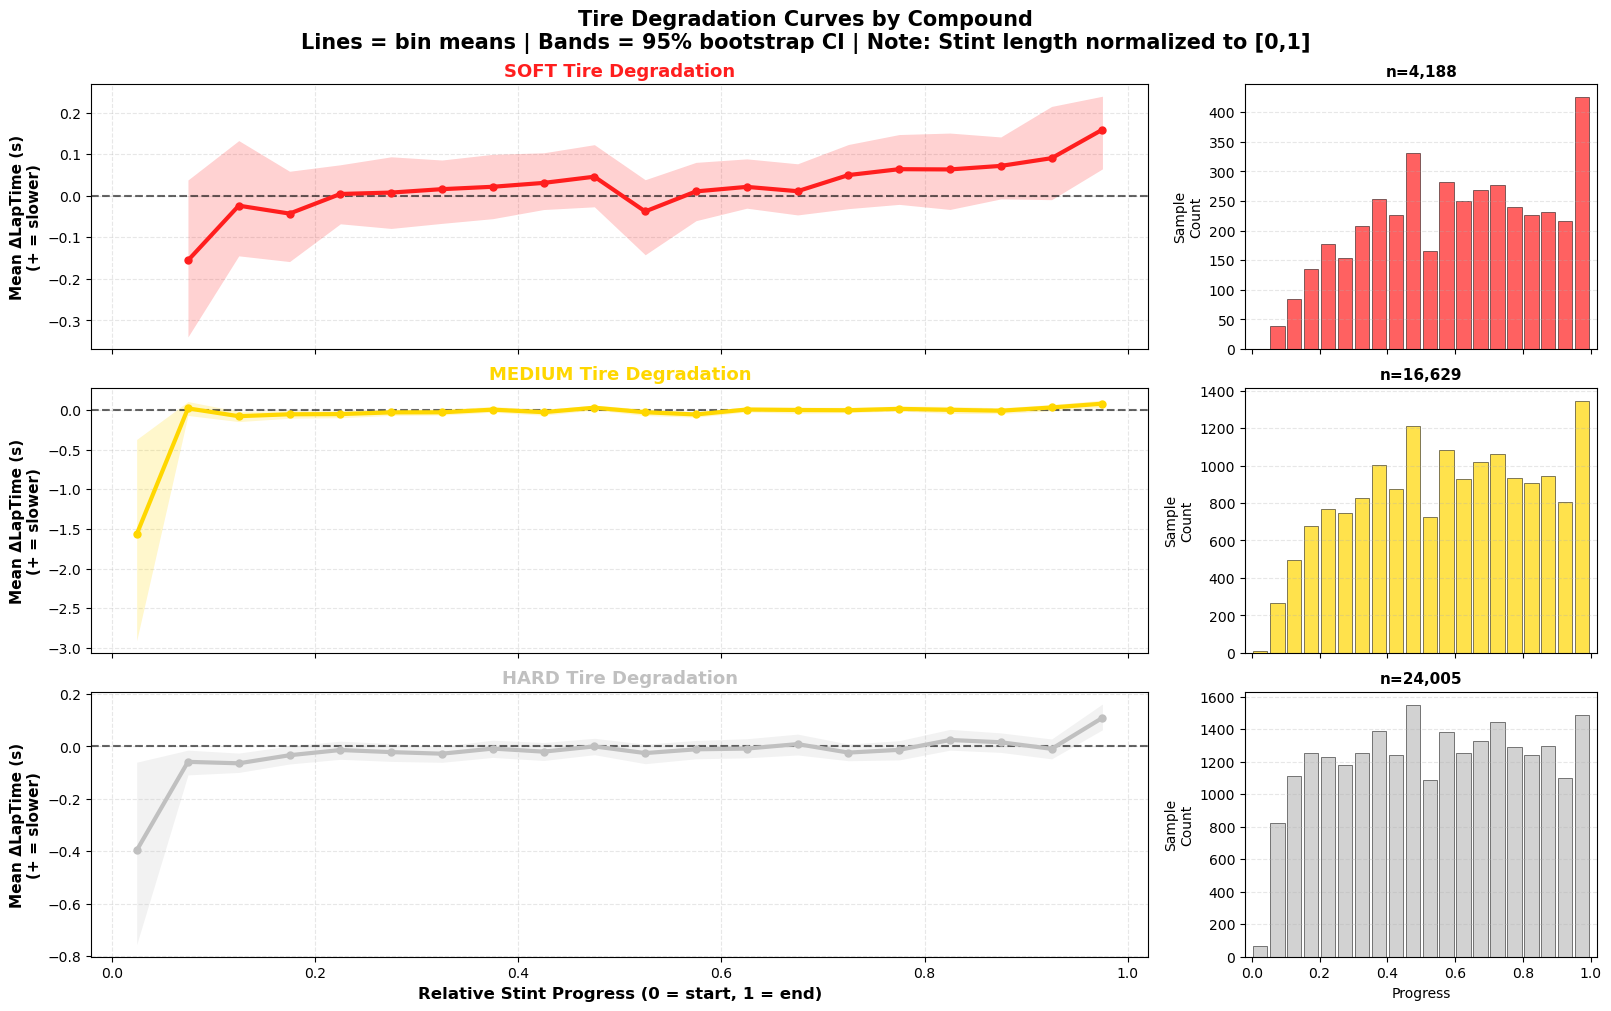

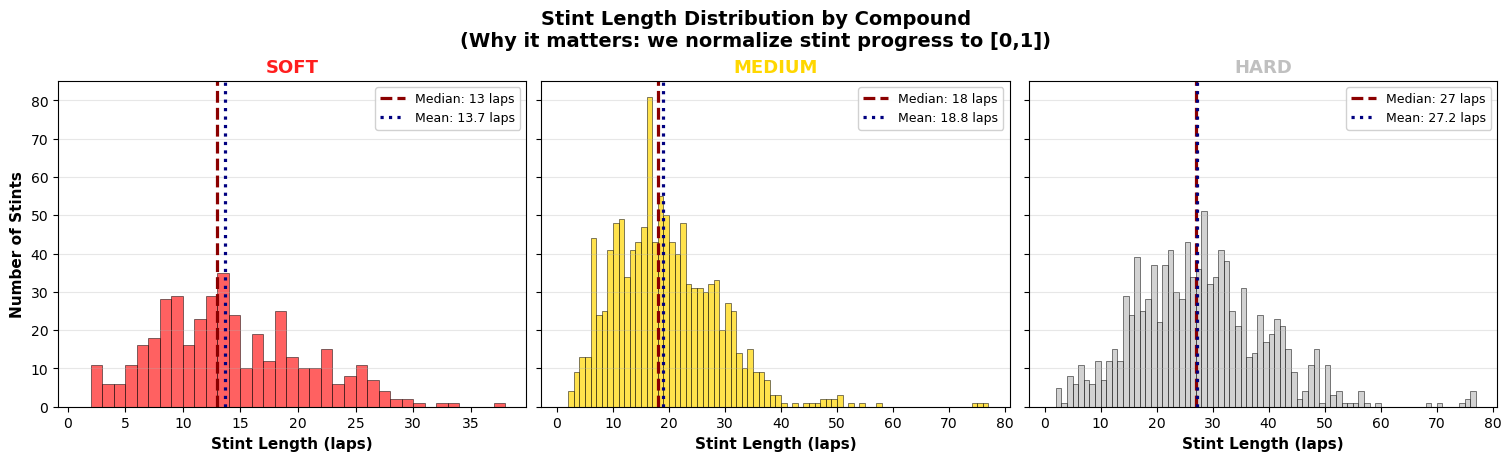


ΔLapTime: Early vs Late by Compound

Compound   Early (0-10%)   Late (90-100%)  Δ (Late-Early)  Total n   
SOFT       -0.1558s        +0.1247s        +0.2804s           4,188
MEDIUM     -0.7738s        +0.0572s        +0.8310s          16,629
HARD       -0.2282s        +0.0496s        +0.2778s          24,005


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Helpers
def _bootstrap_ci_mean(x, n_boot=2000, alpha=0.05, seed=42):
    """Return (mean, lower, upper) via bootstrap percentile CI."""
    x = np.asarray(pd.Series(x).dropna(), float)
    if x.size == 0:
        return np.nan, np.nan, np.nan
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, x.size), replace=True).mean(axis=1)
    lo, hi = np.percentile(boots, [100*alpha/2, 100*(1-alpha/2)])
    return float(x.mean()), float(lo), float(hi)

def summarize_degradation(df, bins=np.linspace(0, 1, 21)):
    """
    Bin rel_stint_progress and compute mean ΔLapTime with 95% CI and counts per compound.
    Returns a tidy summary DataFrame.
    """
    keep = df[df["Compound"].isin(["SOFT","MEDIUM","HARD"])].copy()
    keep["bin"] = pd.cut(keep["rel_stint_progress"], bins=bins, include_lowest=True, right=True)
    mids = keep["bin"].cat.categories.mid
    rows = []
    for comp, g in keep.groupby("Compound", observed=True):
        for i, cat in enumerate(g["bin"].cat.categories):
            vals = g.loc[g["bin"] == cat, "delta_laptime"]
            mean, lo, hi = _bootstrap_ci_mean(vals)
            rows.append({
                "Compound": comp,
                "bin": cat,
                "mid": mids[i],
                "mean": mean, "lo": lo, "hi": hi,
                "n": int(vals.notna().sum())
            })
    out = pd.DataFrame(rows)
    return out[out["n"] > 0].sort_values(["Compound","mid"]).reset_index(drop=True)

# Plots
def plot_degradation_curves(summary, bins=np.linspace(0,1,21)):
    """
    Figure 1: Degradation curves per compound (left) + sample counts (right).
    Simple, readable, no extra stats.
    """
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    compounds = ["SOFT","MEDIUM","HARD"]
    fig = plt.figure(figsize=(16, 10), constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig, 
                  width_ratios=[3, 1], height_ratios=[1, 1, 1])
    
    for r, comp in enumerate(compounds):
        s = summary[summary["Compound"] == comp]
        ax_curve = fig.add_subplot(gs[r, 0])
        ax_count = fig.add_subplot(gs[r, 1])
        
        # Curve with 95% CI
        ax_curve.plot(s["mid"], s["mean"], lw=3, color=colors[comp], marker='o', ms=5, zorder=3)
        ax_curve.fill_between(s["mid"], s["lo"], s["hi"], color=colors[comp], alpha=0.20, zorder=2, lw=0)
        ax_curve.axhline(0, color="black", ls="--", lw=1.5, alpha=0.6)
        ax_curve.set_xlim(-0.02, 1.02)
        ax_curve.set_ylabel("Mean ΔLapTime (s)\n(+ = slower)", fontsize=11, fontweight='bold')
        ax_curve.set_title(f"{comp} Tire Degradation", fontsize=13, color=colors[comp], fontweight="bold")
        ax_curve.grid(True, alpha=0.3, ls="--")
        if r == 2:
            ax_curve.set_xlabel("Relative Stint Progress (0 = start, 1 = end)", fontsize=12, fontweight='bold')
        else:
            ax_curve.set_xticklabels([])
        
        # Counts (bar height = n per bin)
        width = (bins[1]-bins[0]) * 0.85
        ax_count.bar(s["mid"], s["n"], width=width, color=colors[comp], alpha=0.7,
                     edgecolor='black', linewidth=0.5)
        ax_count.set_xlim(-0.02, 1.02)
        ax_count.set_ylabel("Sample\nCount", fontsize=10)
        ax_count.set_title(f"n={s['n'].sum():,}", fontsize=11, fontweight="bold")
        ax_count.grid(True, axis="y", alpha=0.3, ls="--")
        ax_count.ticklabel_format(style='plain', axis='y')
        if r == 2:
            ax_count.set_xlabel("Progress", fontsize=10)
        else:
            ax_count.set_xticklabels([])
    
    fig.suptitle("Tire Degradation Curves by Compound\n"
                 "Lines = bin means | Bands = 95% bootstrap CI | "
                 "Note: Stint length normalized to [0,1]",
                 fontsize=15, fontweight='bold')
    
    plt.savefig('degradation_curves_separated.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_stint_length_distribution(df):
    """
    Figure 2: Stint-length histograms per compound (context for normalization).
    """
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    compounds = ["SOFT","MEDIUM","HARD"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True, constrained_layout=True)
    
    for ax, comp in zip(axes, compounds):
        d = df[df["Compound"] == comp]
        if d.empty:
            ax.axis("off")
            continue
        
        # unique stint lengths
        stints = d.groupby(["year","round","RacingNumber","Stint"])["stint_length"].first()
        bins = range(1, int(stints.max())+2)
        ax.hist(stints, bins=bins, color=colors[comp], alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(stints.median(), color='darkred', ls='--', lw=2.3, label=f"Median: {stints.median():.0f} laps")
        ax.axvline(stints.mean(),   color='navy',    ls=':',  lw=2.3, label=f"Mean: {stints.mean():.1f} laps")
        ax.set_title(comp, fontsize=13, fontweight="bold", color=colors[comp])
        ax.set_xlabel("Stint Length (laps)", fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.legend(fontsize=9, framealpha=0.9)
    
    axes[0].set_ylabel("Number of Stints", fontsize=11, fontweight='bold')
    fig.suptitle("Stint Length Distribution by Compound\n(Why it matters: we normalize stint progress to [0,1])",
                 fontsize=14, fontweight='bold')
    
    plt.savefig('stint_length_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()



# Build the summary once
_bins = np.linspace(0, 1, 21)  # 20 bins, 5%-wide each
summary = summarize_degradation(df_pairs, bins=_bins)

# Figure 1: degradation curves + counts
plot_degradation_curves(summary, bins=_bins)

# Figure 2: stint-length context
plot_stint_length_distribution(df_pairs)

# Print Early vs Late summary table

print(f"\nΔLapTime: Early vs Late by Compound")
print(f"\n{'Compound':<10} {'Early (0-10%)':<15} {'Late (90-100%)':<15} {'Δ (Late-Early)':<15} {'Total n':<10}")


for comp in ["SOFT", "MEDIUM", "HARD"]:
    s = summary[summary["Compound"] == comp]
    early = s.loc[s["mid"] <= 0.10, "mean"].mean()
    late = s.loc[s["mid"] >= 0.90, "mean"].mean()
    delta = (late - early) if np.isfinite(early) and np.isfinite(late) else np.nan
    n_tot = int(s["n"].sum())
    
    print(f"{comp:<10} {early:+.4f}s        {late:+.4f}s        {delta:+.4f}s        {n_tot:>8,}")


<h1><center> Weather influence on delta lap time  </center></h1>


WEATHER EFFECTS ON TIRE DEGRADATION

Available weather columns: ['AirTemp', 'Humidity', 'TrackTemp', 'WindDirection', 'WindSpeed', 'Rainfall']
Total lap pairs: 44,822

[1/4] Generating hexbin: ΔLapTime vs Track Temperature...


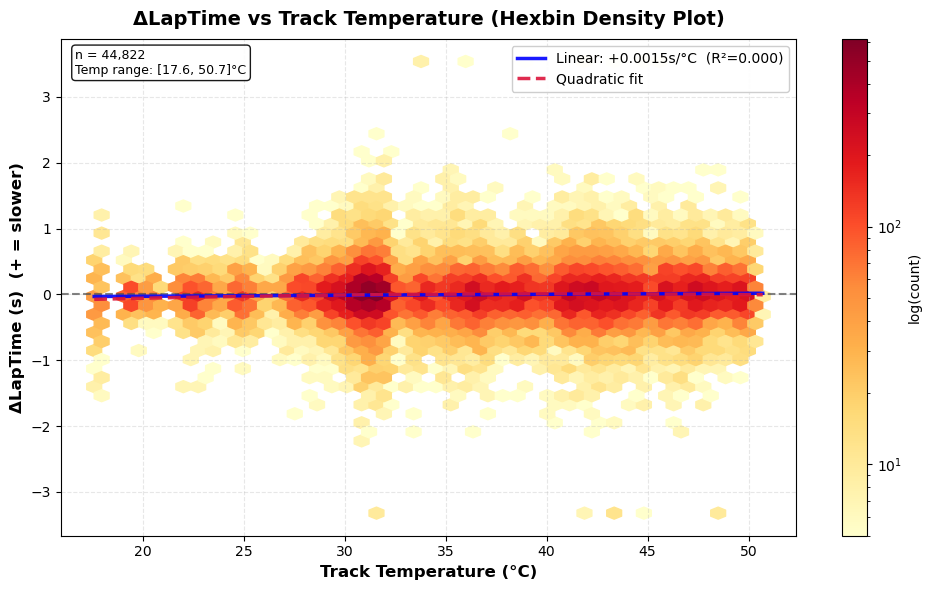


[2/4] Generating binned means by temperature...


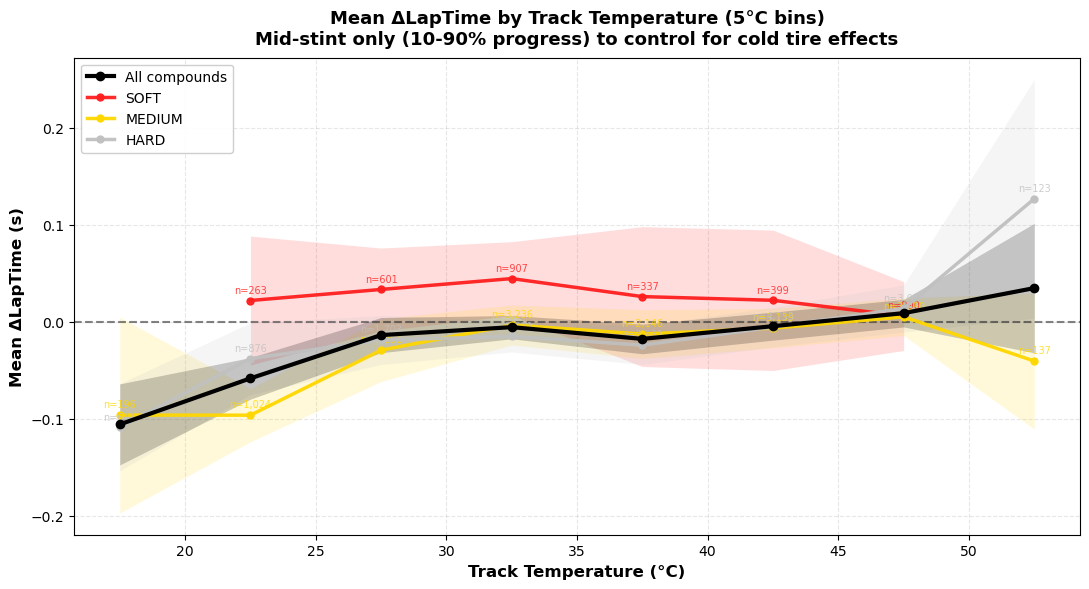


TEMPERATURE SENSITIVITY BY COMPOUND (Linear Regression)
Compound   Slope (s/°C)    R²       p-value      n         
----------------------------------------------------------------------
ALL        +0.00165         0.0004   2.2319e-05   44,822    
SOFT       -0.00093         0.0001   4.3893e-01   4,188     
MEDIUM     +0.00199         0.0007   5.3752e-04   16,629    
HARD       +0.00195         0.0005   7.0656e-04   24,005    
Interpretation:
  • Positive slope = hotter track → slower laps (degradation increases)
  • Compare slopes: which compound is most heat-sensitive?

[3/4] Generating temperature × stint progress interaction...


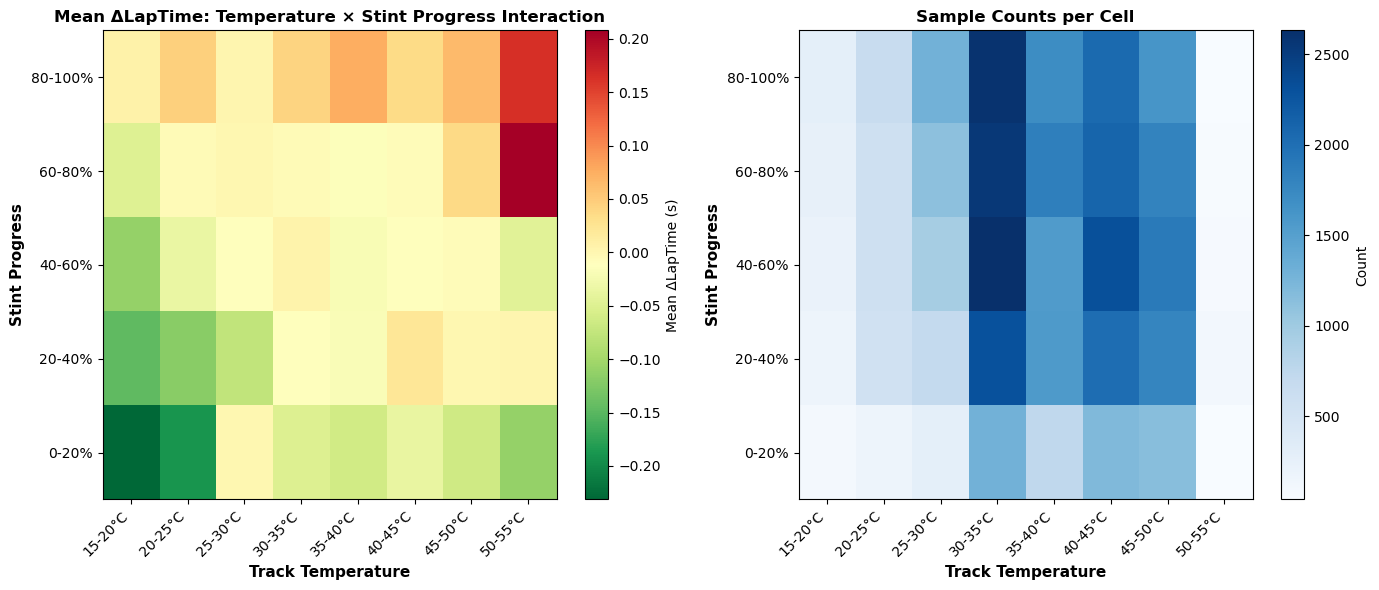


INTERACTION INTERPRETATION
✓ Look for gradient change from left (cool) to right (hot)
✓ If hot+late-stint is redder → heat accelerates degradation
✓ If pattern is horizontal → no interaction (additive effects)

✓ Analysis complete! Check generated PNG files.


In [20]:
"""
Weather Effects on Tire Degradation
====================================
Analyzes how track temperature, wind, and rainfall affect lap-to-lap delta times.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec

# ---------- Helpers ----------
def _clean(df, cols):
    return df.dropna(subset=cols).copy()

def _bin_stats(x, y, bins, ci_alpha=0.05, min_n=50):
    """Return DataFrame with bin midpoints, mean, CI, and counts."""
    cut = pd.cut(x, bins=bins, include_lowest=True)
    g = pd.DataFrame({"y": y, "bin": cut}).dropna()
    stats = g.groupby("bin")["y"].agg(['mean','count','std'])
    stats = stats[stats['count'] >= min_n]
    # normal approx CI (large n)
    z = 1.96 if ci_alpha == 0.05 else 2.58 if ci_alpha <= 0.01 else 1.64
    stats["se"] = stats["std"] / np.sqrt(stats["count"])
    stats["lo"] = stats["mean"] - z * stats["se"]
    stats["hi"] = stats["mean"] + z * stats["se"]
    stats["mid"] = stats.index.map(lambda iv: 0.5*(iv.left + iv.right))
    return stats.reset_index(drop=True)

def _winsor(x, p=0.005):
    lo, hi = x.quantile([p, 1-p])
    return x.clip(lo, hi)

def _wind_quadrant(deg):
    """Map wind direction to N/E/S/W quadrants."""
    return np.select(
        [(deg>=315)|(deg<45), (deg>=45)&(deg<135), (deg>=135)&(deg<225), (deg>=225)&(deg<315)],
        ["N", "E", "S", "W"],
        default=np.nan
    )


# ---------- A) Hexbin: Δ vs Track Temp ----------
def plot_hexbin_tracktemp(df, gridsize=40):
    """Dense scatter showing temperature effect with linear + quadratic fits."""
    d = _clean(df, ["delta_laptime","TrackTemp"])
    y = _winsor(d["delta_laptime"], 0.002)
    x = d["TrackTemp"]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    hb = ax.hexbin(x, y, gridsize=gridsize, bins='log', mincnt=5, cmap='YlOrRd')
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("log(count)", fontsize=10)
    
    ax.axhline(0, ls="--", c="0.3", lw=1.5, alpha=0.7)
    ax.set_xlabel("Track Temperature (°C)", fontsize=12, fontweight='bold')
    ax.set_ylabel("ΔLapTime (s)  (+ = slower)", fontsize=12, fontweight='bold')
    ax.set_title("ΔLapTime vs Track Temperature (Hexbin Density Plot)", 
                 fontsize=14, fontweight='bold', pad=10)
    
    # Linear fit
    m = ~x.isna() & ~y.isna()
    slope, intercept, r, p, _ = linregress(x[m], y[m])
    xx = np.linspace(x.min(), x.max(), 100)
    ax.plot(xx, intercept + slope*xx, c="blue", lw=2.5, alpha=0.9, 
            label=f"Linear: {slope:+.4f}s/°C  (R²={r**2:.3f})")
    
    # Quadratic fit (check for non-linearity)
    from numpy.polynomial import Polynomial
    p_quad = Polynomial.fit(x[m], y[m], deg=2)
    ax.plot(xx, p_quad(xx), c="crimson", lw=2.5, ls='--', alpha=0.9,
            label="Quadratic fit")
    
    ax.legend(fontsize=10, framealpha=0.95)
    ax.grid(alpha=0.3, ls="--")
    
    # Add stats box
    stats_text = f"n = {len(d):,}\nTemp range: [{x.min():.1f}, {x.max():.1f}]°C"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=9, va='top', bbox=dict(boxstyle='round', fc='white', alpha=0.9))
    
    plt.tight_layout()
    plt.savefig('weather_hexbin_tracktemp.png', dpi=300, bbox_inches='tight')
    plt.show()


# ---------- B) Binned: Mean Δ by Track Temp ----------
def plot_temp_bins(df, bin_width=5, ci_alpha=0.05):
    """Mean ΔLapTime across temperature bins, faceted by compound."""
    d = _clean(df, ["delta_laptime","TrackTemp","Compound","rel_stint_progress"])
    
    # Mid-stint only (10-90%) to reduce pit stop / cold tire confounders
    mid = d[(d["rel_stint_progress"]>=0.1) & (d["rel_stint_progress"]<=0.9)].copy()
    temp = mid["TrackTemp"]
    y = mid["delta_laptime"]
    
    tmin = np.floor(temp.min()/bin_width)*bin_width
    tmax = np.ceil(temp.max()/bin_width)*bin_width
    bins = np.arange(tmin, tmax+bin_width, bin_width)
    
    stats_all = _bin_stats(temp, y, bins, ci_alpha=ci_alpha, min_n=100)
    
    fig, ax = plt.subplots(figsize=(11, 6))
    
    # Overall trend (all compounds)
    ax.plot(stats_all["mid"], stats_all["mean"], marker="o", ms=6, lw=3, 
            label="All compounds", color="black", zorder=4)
    ax.fill_between(stats_all["mid"], stats_all["lo"], stats_all["hi"], 
                     alpha=0.20, color="black", lw=0, zorder=3)
    
    # Compound-specific trends
    colors = {"SOFT":"#FF1E1E", "MEDIUM":"#FFD700", "HARD":"#C0C0C0"}
    for c in ["SOFT", "MEDIUM", "HARD"]:
        sub = mid[mid["Compound"]==c]
        if len(sub) < 100:
            continue
        s = _bin_stats(sub["TrackTemp"], sub["delta_laptime"], bins, 
                       ci_alpha=ci_alpha, min_n=40)
        if len(s) == 0:
            continue
        ax.plot(s["mid"], s["mean"], marker="o", ms=5, lw=2.5, 
                label=c, color=colors[c], alpha=0.95, zorder=3)
        ax.fill_between(s["mid"], s["lo"], s["hi"], 
                        alpha=0.15, color=colors[c], lw=0, zorder=2)
        
        # Add sample counts as text
        for i, row in s.iterrows():
            ax.text(row["mid"], row["mean"] + 0.008, f"n={int(row['count']):,}",
                    ha='center', fontsize=7, color=colors[c], alpha=0.8)
    
    ax.axhline(0, ls="--", c="0.3", lw=1.5, alpha=0.7)
    ax.set_xlabel("Track Temperature (°C)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Mean ΔLapTime (s)", fontsize=12, fontweight='bold')
    ax.set_title(f"Mean ΔLapTime by Track Temperature ({bin_width}°C bins)\n" +
                 "Mid-stint only (10-90% progress) to control for cold tire effects",
                 fontsize=13, fontweight='bold', pad=10)
    ax.legend(frameon=True, fontsize=10, framealpha=0.95)
    ax.grid(alpha=0.3, ls="--")
    
    plt.tight_layout()
    plt.savefig('weather_temp_bins.png', dpi=300, bbox_inches='tight')
    plt.show()


# ---------- C) Temperature Sensitivity by Compound ----------
def print_temp_sensitivity(df):
    """Print linear slopes: how many seconds per °C for each compound."""
    print("\n" + "="*70)
    print("TEMPERATURE SENSITIVITY BY COMPOUND (Linear Regression)")
    print("="*70)
    print(f"{'Compound':<10} {'Slope (s/°C)':<15} {'R²':<8} {'p-value':<12} {'n':<10}")
    print("-"*70)
    
    d = df.dropna(subset=["delta_laptime", "TrackTemp", "Compound"]).copy()
    
    # Overall
    slope, _, r, p, _ = linregress(d["TrackTemp"], d["delta_laptime"])
    print(f"{'ALL':<10} {slope:+.5f}         {r**2:<8.4f} {p:<12.4e} {len(d):<10,}")
    
    # Per compound
    for comp in ["SOFT", "MEDIUM", "HARD"]:
        sub = d[d["Compound"] == comp]
        if len(sub) > 100:
            slope, _, r, p, _ = linregress(sub["TrackTemp"], sub["delta_laptime"])
            print(f"{comp:<10} {slope:+.5f}         {r**2:<8.4f} {p:<12.4e} {len(sub):<10,}")
    
    print("="*70)
    print("Interpretation:")
    print("  • Positive slope = hotter track → slower laps (degradation increases)")
    print("  • Compare slopes: which compound is most heat-sensitive?")
    print("="*70)


# ---------- D) Interaction: Temperature × Stint Progress ----------
def plot_temp_stint_interaction(df):
    """Heatmap showing if heat accelerates late-stint degradation."""
    d = df.dropna(subset=["delta_laptime", "TrackTemp", "rel_stint_progress"]).copy()
    
    temp_bins = pd.cut(d["TrackTemp"], bins=np.arange(15, 56, 5))
    prog_bins = pd.cut(d["rel_stint_progress"], bins=np.linspace(0, 1, 6), 
                       labels=["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"])
    
    pivot = d.groupby([temp_bins, prog_bins])["delta_laptime"].mean().unstack()
    counts = d.groupby([temp_bins, prog_bins]).size().unstack()
    
    fig, (ax, ax_count) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Mean ΔLapTime
    im = ax.imshow(pivot.T, aspect='auto', cmap='RdYlGn_r', origin='lower')
    ax.set_yticks(range(len(pivot.columns)))
    ax.set_yticklabels(pivot.columns)
    ax.set_xticks(range(len(pivot.index)))
    ax.set_xticklabels([f"{int(iv.left)}-{int(iv.right)}°C" 
                        for iv in pivot.index], rotation=45, ha='right')
    ax.set_xlabel("Track Temperature", fontsize=11, fontweight='bold')
    ax.set_ylabel("Stint Progress", fontsize=11, fontweight='bold')
    ax.set_title("Mean ΔLapTime: Temperature × Stint Progress Interaction", 
                 fontsize=12, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Mean ΔLapTime (s)", fontsize=10)
    
    # Sample counts
    im2 = ax_count.imshow(counts.T, aspect='auto', cmap='Blues', origin='lower')
    ax_count.set_yticks(range(len(counts.columns)))
    ax_count.set_yticklabels(counts.columns)
    ax_count.set_xticks(range(len(counts.index)))
    ax_count.set_xticklabels([f"{int(iv.left)}-{int(iv.right)}°C" 
                              for iv in counts.index], rotation=45, ha='right')
    ax_count.set_xlabel("Track Temperature", fontsize=11, fontweight='bold')
    ax_count.set_ylabel("Stint Progress", fontsize=11, fontweight='bold')
    ax_count.set_title("Sample Counts per Cell", fontsize=12, fontweight='bold')
    
    cbar2 = fig.colorbar(im2, ax=ax_count)
    cbar2.set_label("Count", fontsize=10)
    
    plt.tight_layout()
    plt.savefig('weather_temp_stint_interaction.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*70)
    print("INTERACTION INTERPRETATION")
    print("="*70)
    print("✓ Look for gradient change from left (cool) to right (hot)")
    print("✓ If hot+late-stint is redder → heat accelerates degradation")
    print("✓ If pattern is horizontal → no interaction (additive effects)")
    print("="*70)


# ---------- RUN ANALYSIS ----------
if __name__ == "__main__":
    # Assumes df_pairs is loaded
    print("\n" + "="*70)
    print("WEATHER EFFECTS ON TIRE DEGRADATION")
    print("="*70)
    
    # Check available weather columns
    weather_cols = [c for c in df_pairs.columns if c in 
                    ["TrackTemp", "AirTemp", "Humidity", "Rainfall", 
                     "WindSpeed", "WindDirection"]]
    print(f"\nAvailable weather columns: {weather_cols}")
    print(f"Total lap pairs: {len(df_pairs):,}")
    
    # A) Hexbin density plot
    print("\n[1/4] Generating hexbin: ΔLapTime vs Track Temperature...")
    plot_hexbin_tracktemp(df_pairs, gridsize=45)
    
    # B) Binned means with CI
    print("\n[2/4] Generating binned means by temperature...")
    plot_temp_bins(df_pairs, bin_width=5)
    
    # C) Statistical table
    print_temp_sensitivity(df_pairs)
    
    # D) Interaction heatmap
    print("\n[3/4] Generating temperature × stint progress interaction...")
    plot_temp_stint_interaction(df_pairs)
    
    print("\n" + "="*70)
    print("✓ Analysis complete! Check generated PNG files.")
    print("="*70)



In [ ]:
########################################################
# STEP 2.E - RENAME COLUMNS FOR CLARITY
########################################################

print("\n" + "="*70)
print("Renaming columns for clarity (adding _s suffix for seconds)...")
print("="*70)

df_pairs = df_pairs.rename(columns={
    "LapTime": "LapTime_s",
    "LapTime_prev": "LapTime_prev_s",
    "delta_laptime": "delta_laptime_s"
})

print("Renamed columns:")
print("  LapTime → LapTime_s")
print("  LapTime_prev → LapTime_prev_s")
print("  delta_laptime → delta_laptime_s")

print("\n" + "="*70)
print("Degradation modeling dataset ready!")
print("="*70)
print(f"Final shape: {df_pairs.shape}")
print(f"Columns: {df_pairs.columns.tolist()}")
print("\nFirst few rows:")
df_pairs.head(10)